# Análise de Sentimentos em Resenhas de Filmes

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará atingir um valor F1 de pelo menos 0,85.

# Sumário
1. [Inicialização](#1)
2. [Análise Exploratória](#2)
3. [Rotina de Avaliação de Modelos](#3)
4. [Normalização](#4)
5. [Separando Dados](#5)
6. [Modelos](#6)
7. [Testando Modelos](#7)
8. [Conclusão](#8)

## Inicialização <a name='1'></a>

In [1]:
import math

import numpy as np
import pandas as pd
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

lemmatizer = WordNetLemmatizer()

In [2]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [3]:
#configurações do matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# isso é para usar progress_apply
tqdm.pandas()

## Carregando Dados

In [5]:
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Pré-processamento de Dados

Verificando as informações gerais do dataframe

In [6]:
df_reviews.info()
df_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


As colunas `average_rating` e `votes` têm 2 valores ausentes cada. Descartaremos essas linhas com valores ausentes

In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


A partir dos dados pode-se concluir que: 
- O ano de lançamento mais antigo listado é 1894 e o mais recente é 2010. A maioria dos filmes foi lançada entre as décadas de 1980 e 2000.
- A coluna `is_adult` que indica se um filme é destinado a um público adulto, mostra que cerca de 0,17% dos filmes são classificados como adultos (1) e a grande maioria (99,83%) não é classificada como adulta (0).

Em relação aos valores atípicos, é necessário realizar uma análise de visualização dos dados para identificá-los.

In [8]:
df_reviews = df_reviews.dropna()
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

Valores ausentes removidos. Agora veremos se há valores duplicados

In [9]:
df_reviews.duplicated().sum()

0

Nenhuma linha duplicada. Agora verificaremos a distribuição das classes na coluna `pos`, o target.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

Observamos que há equilíbrio das classes 0 e 1

## Análise Exploratória <a name='2'></a>

Verificaremos o número de filmes e críticas ao longo dos anos.

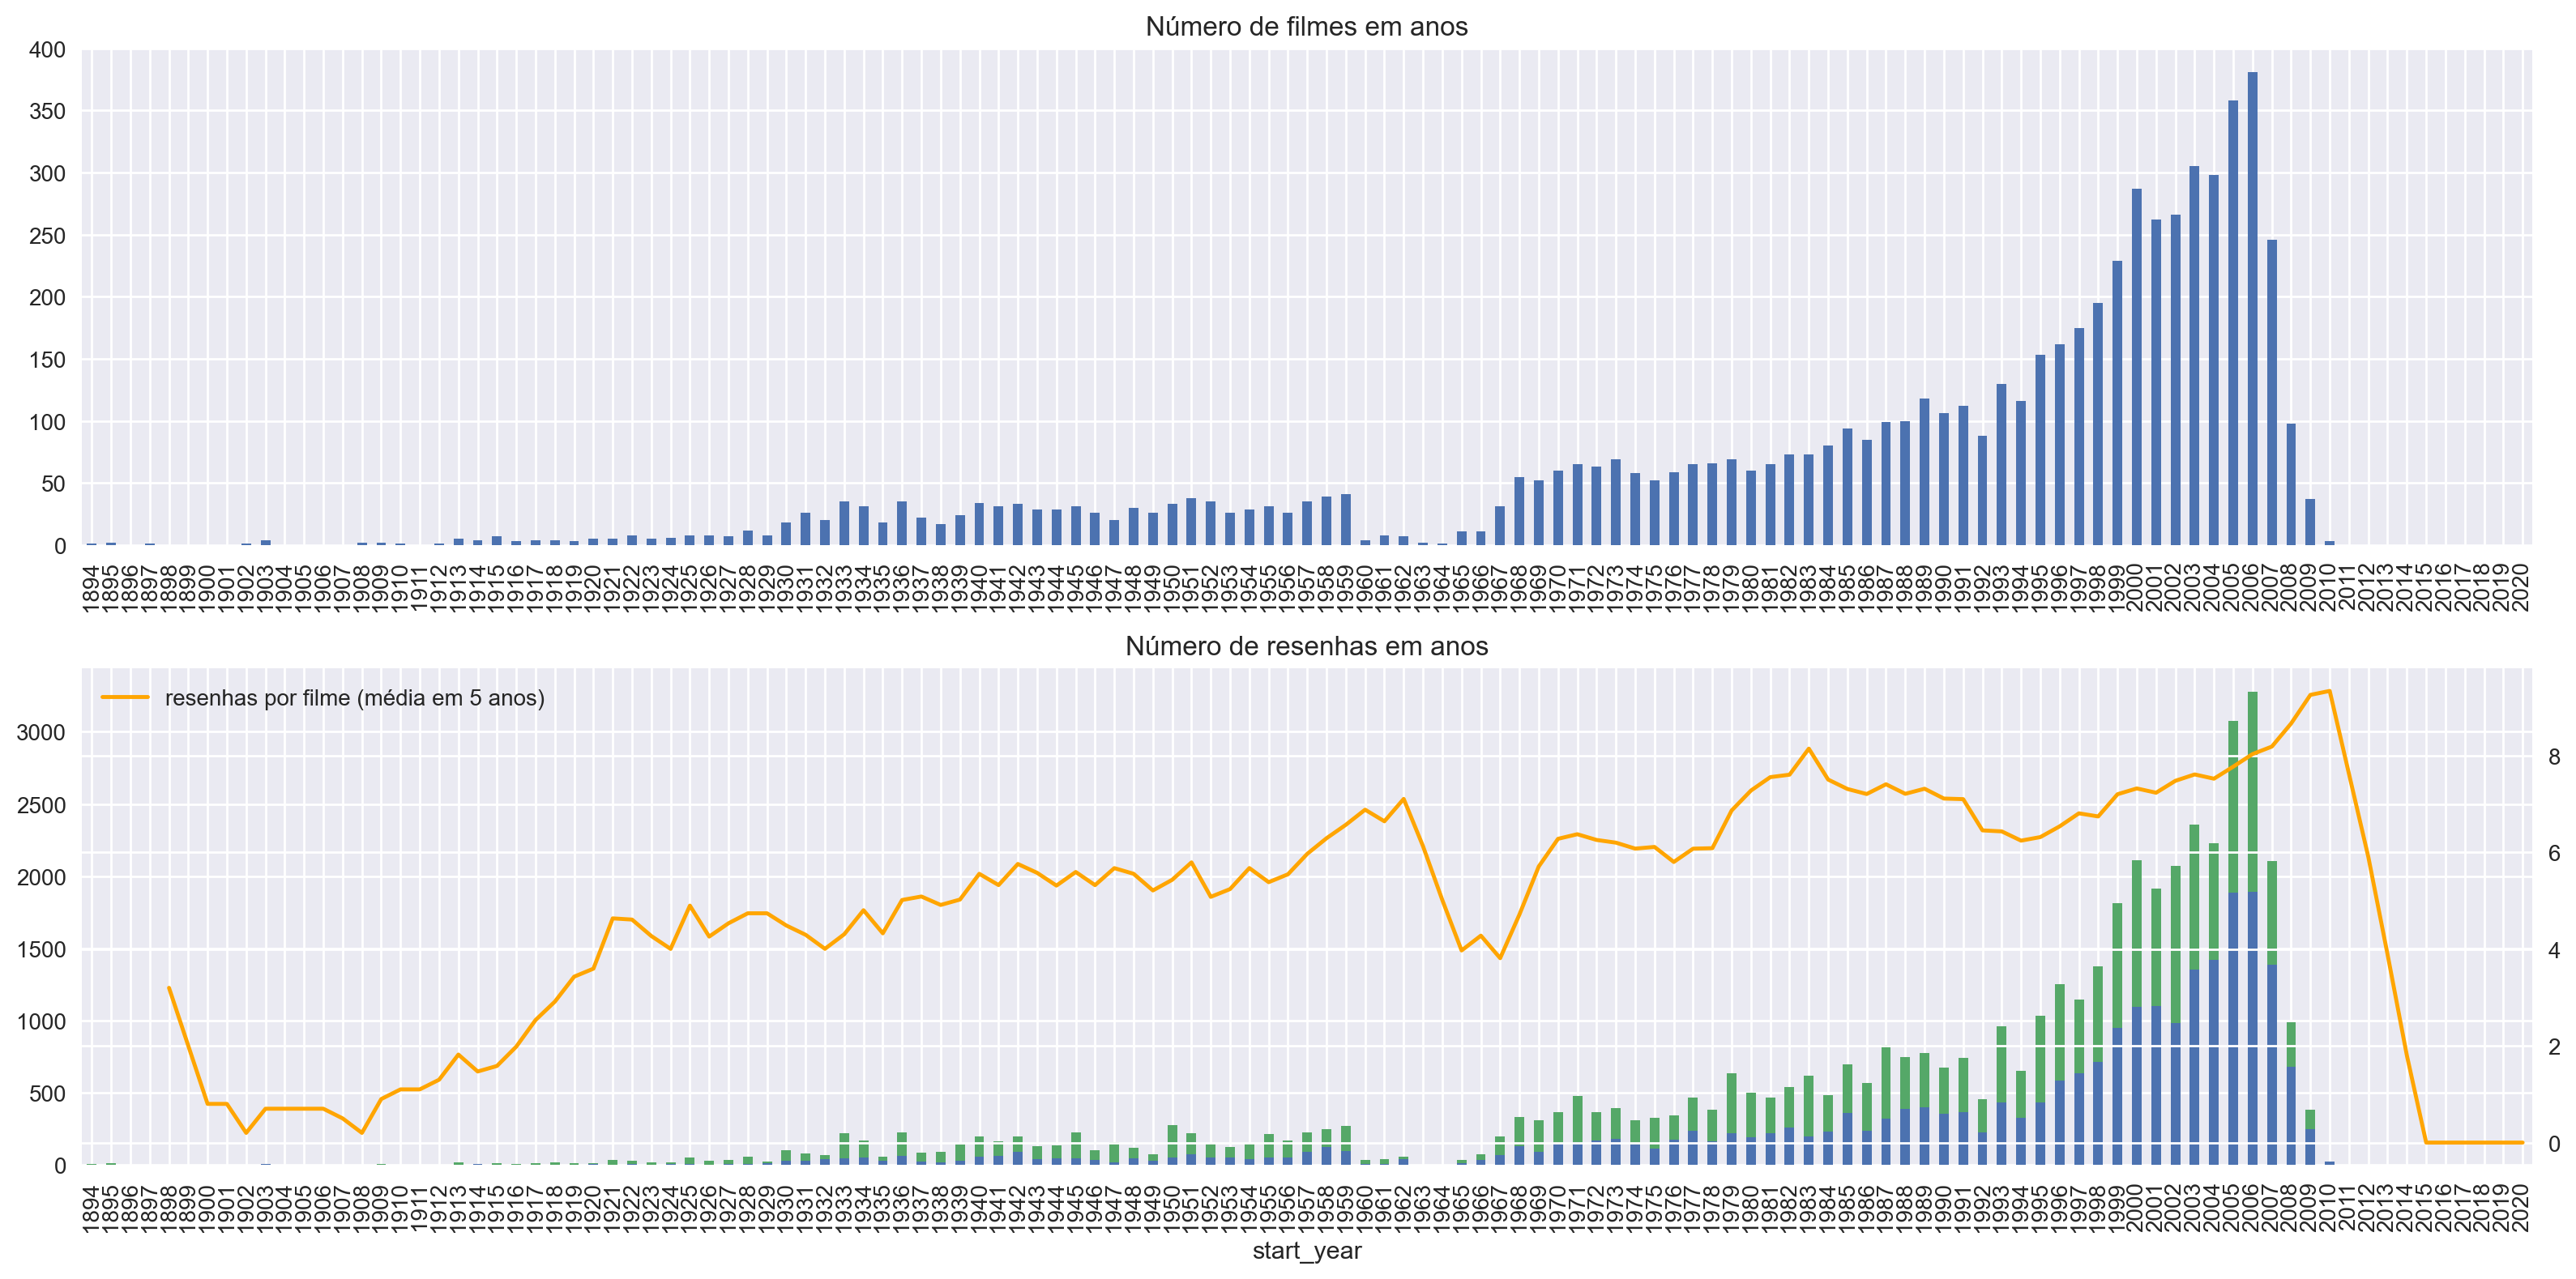

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Observamos um aumento geral no número de filmes com pico em 2006 e queda depois disso, igualmente ao número de resenhas por filme.

Verificaremos a distribuição do número de críticas por filme com a contagem exata e o KDE (apenas para saber como pode diferir da contagem exata)

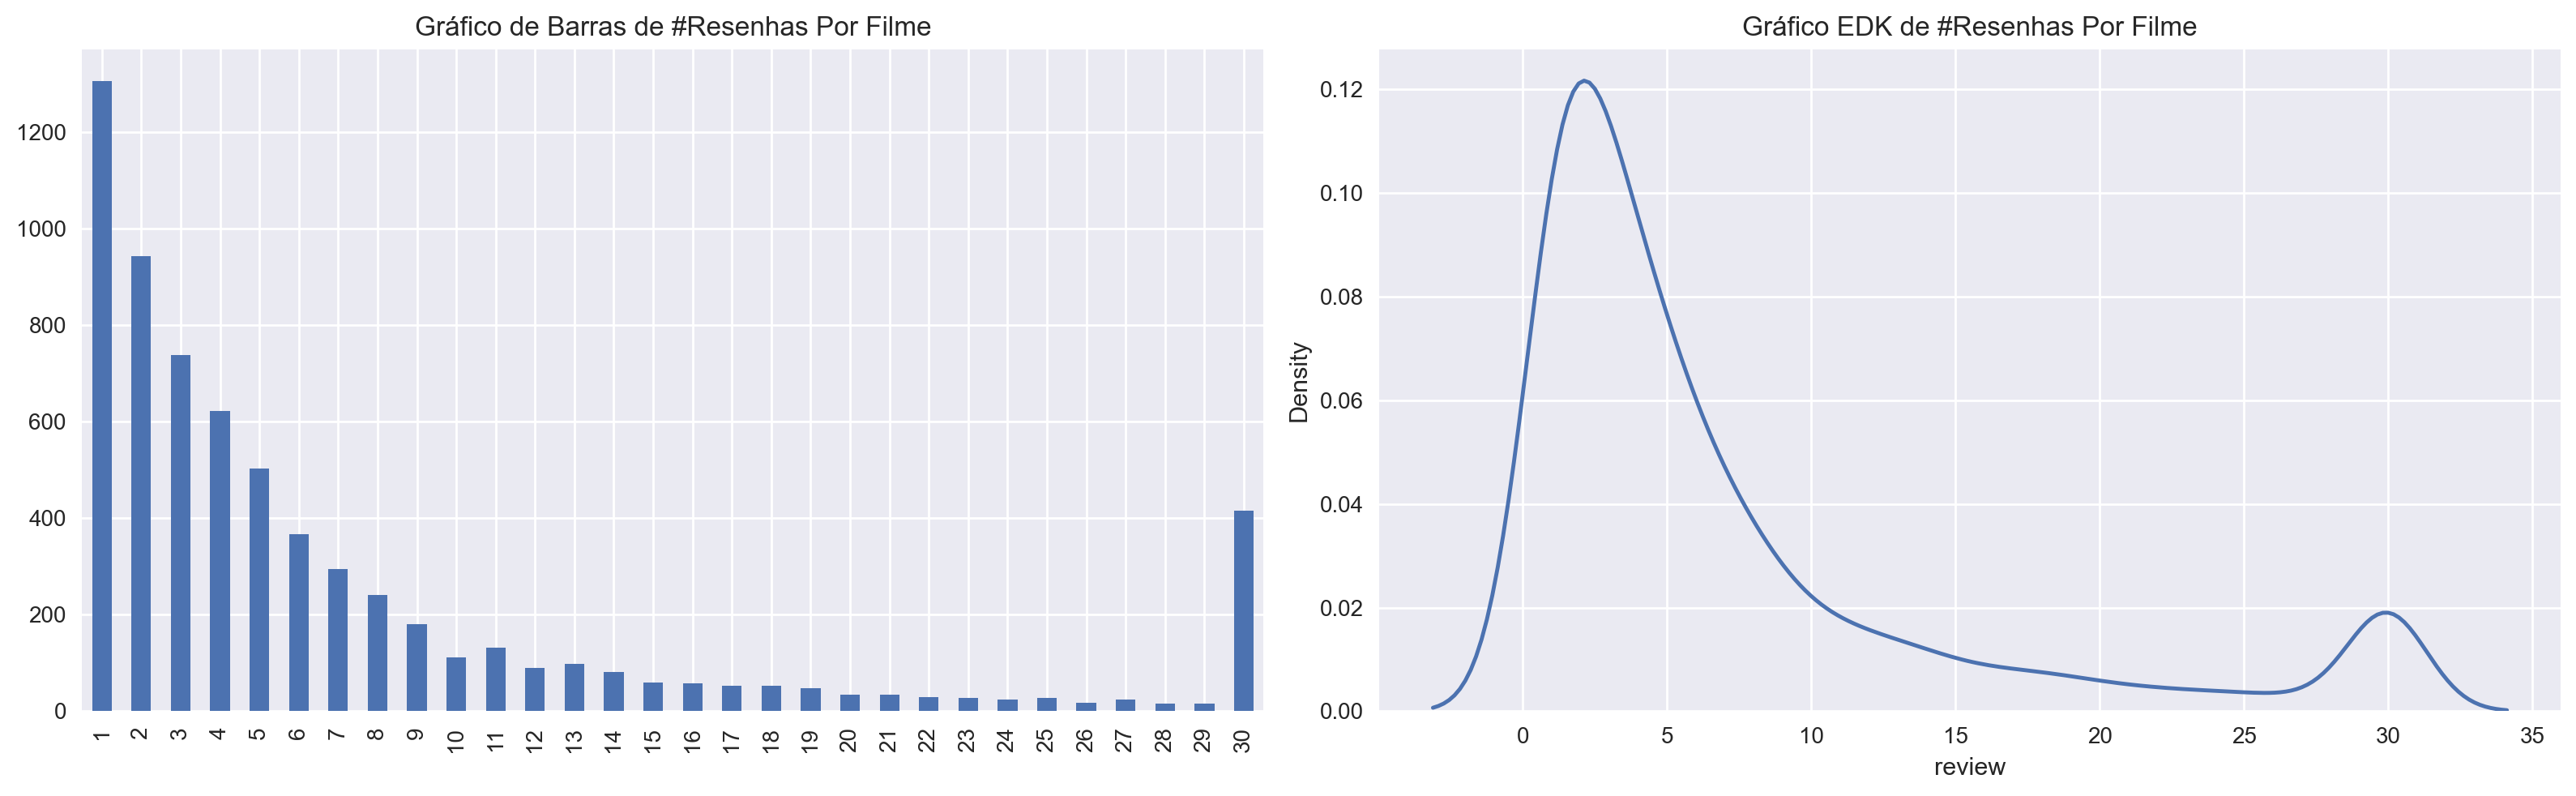

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

Há muito mais filmes com 1 crítica e observamos uma diminuição constante à medida que o número de críticas aumenta e, em seguida, um aumento repentino de 30 críticas. Agora veremos a distribuição de classificações nos conjuntos de treinamento e teste

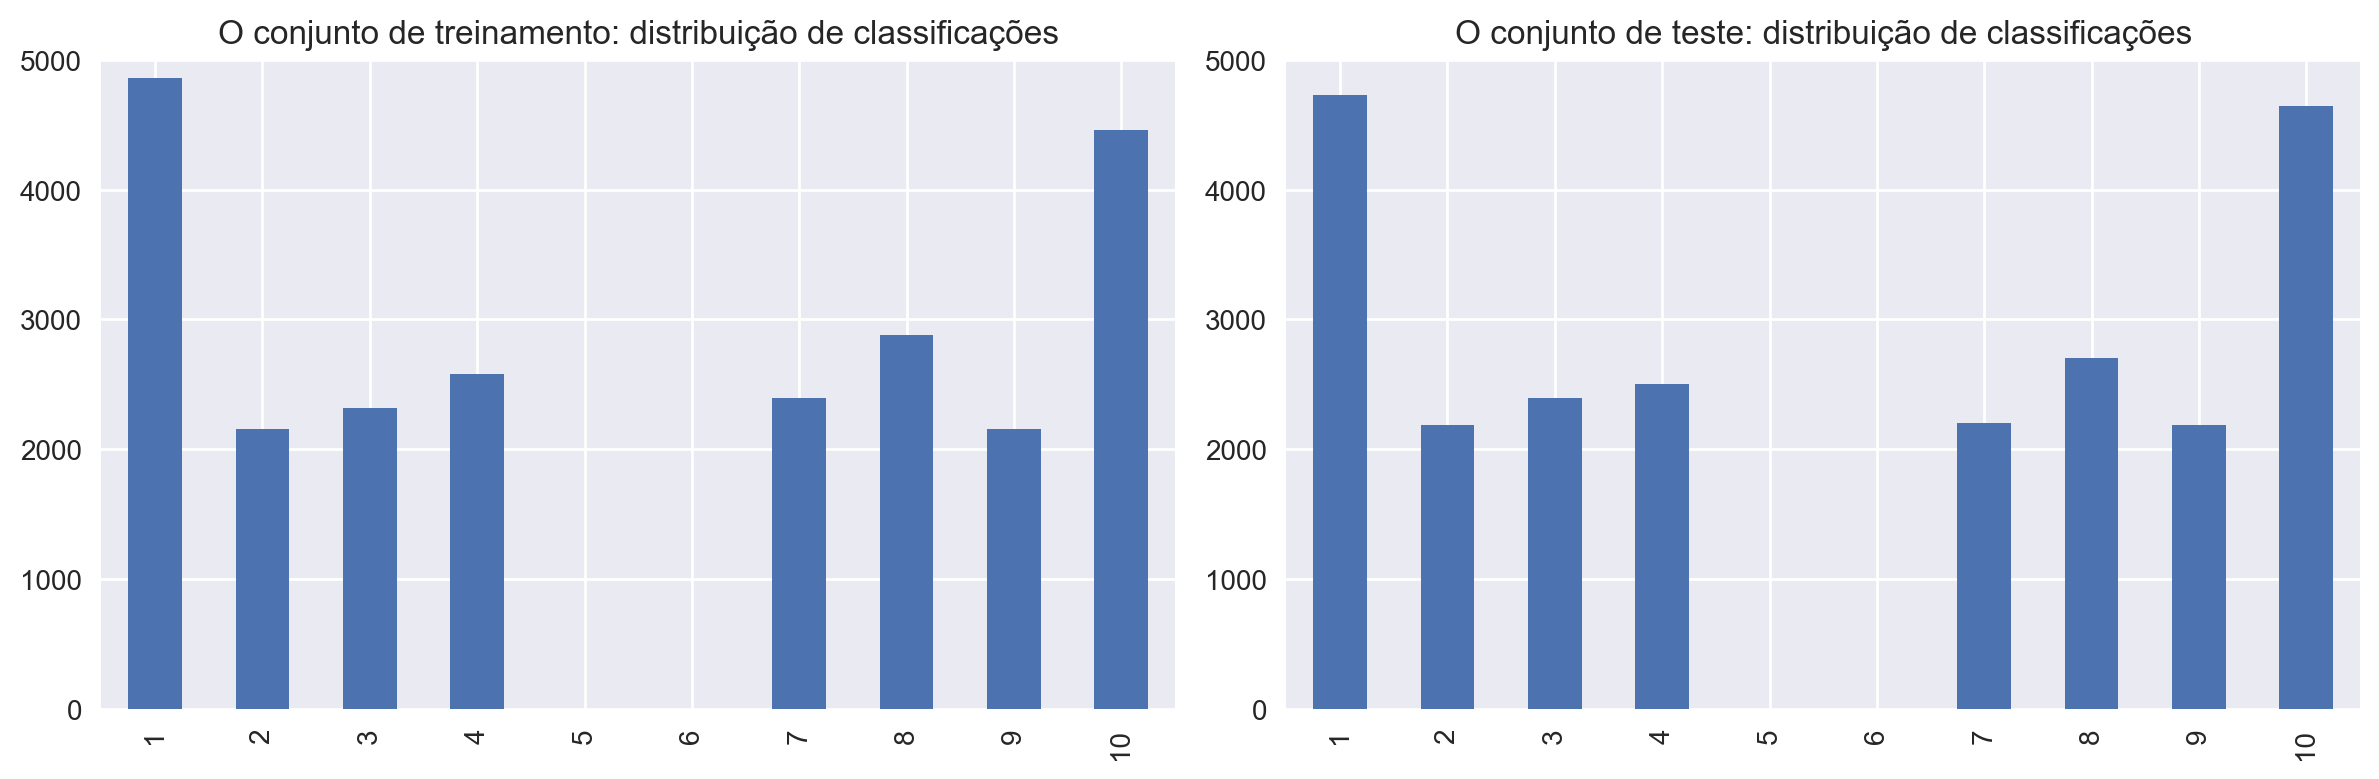

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

As avaliações dos filmes são bastante polarizadas, com muitas resenhas recebendo a classificação mínima de 1 ou a máxima de 10. Por outro lado, há uma quantidade semelhante de resenhas para as classificações intermediárias, como 2, 3 e 4, bem como para as classificações 7, 8 e 9. No entanto, é raro encontrar avaliações médias, como 5 ou 6.

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

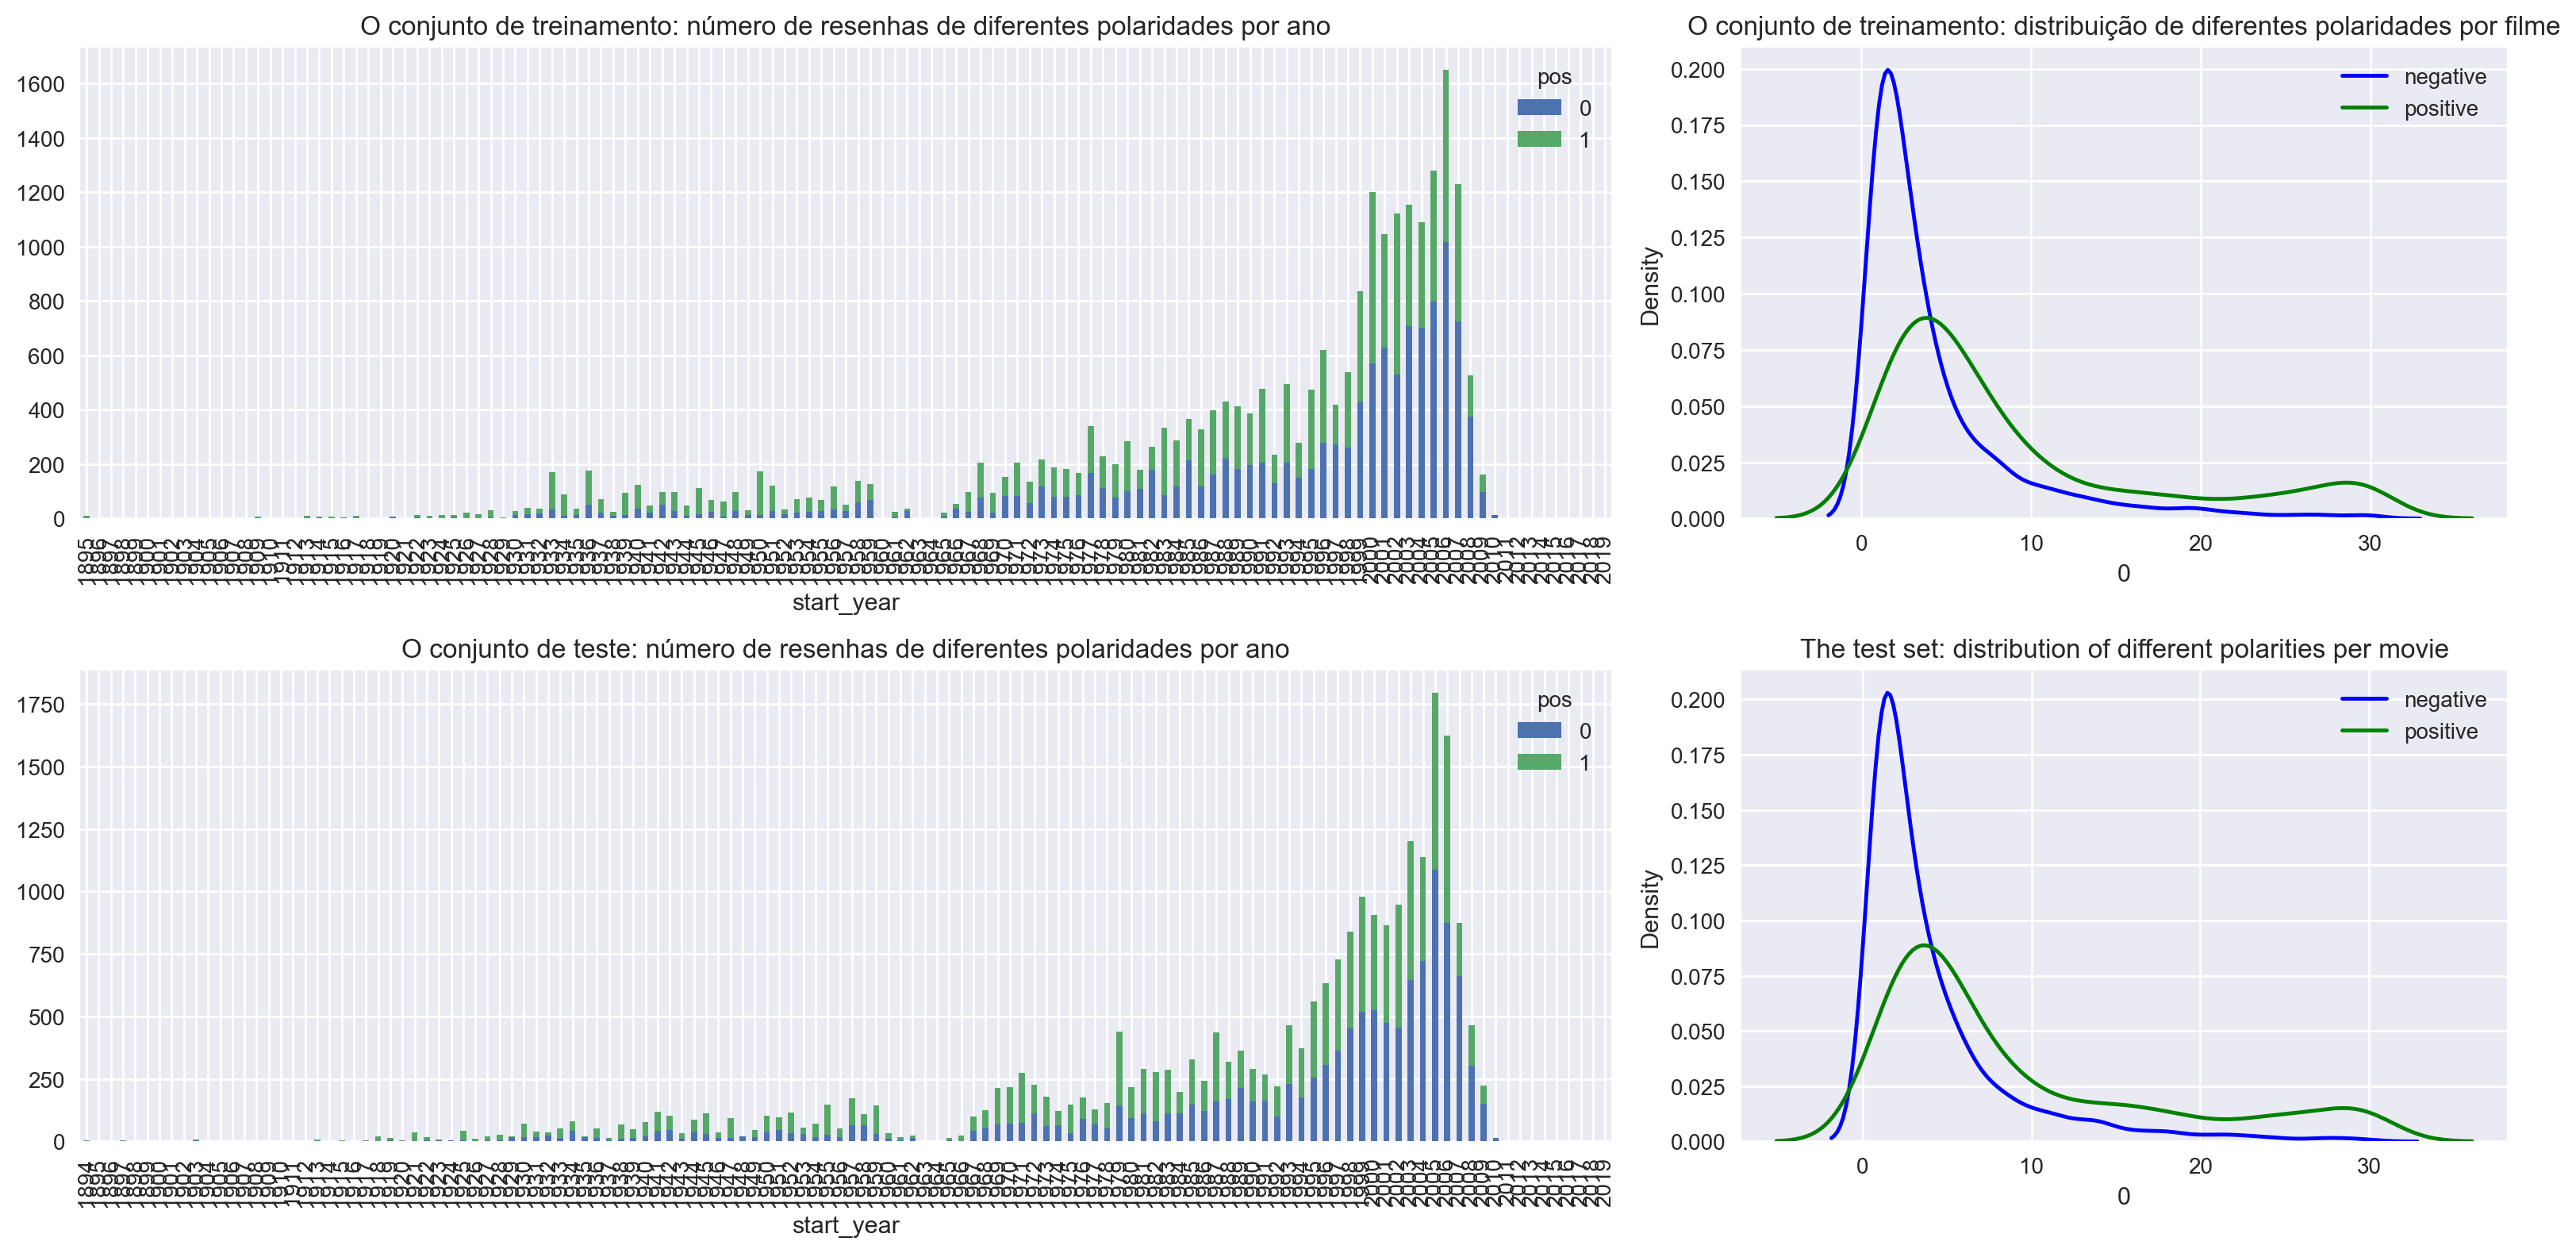

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Na maior parte dos anos, as críticas negativas superaram em número as críticas positivas.

## Rotina de Avaliação de Modelos <a name='3'></a>

Criando uma função de avaliação de modelos para ser usada em todos os modelos ao longo do projeto.

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização <a name='4'></a>

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [16]:
def strip_text(text):
    
    processed = " ".join(re.sub(r"[^a-zA-Z']", " ", text).split())
    return processed.lower()

processed_reviews = []
for row in range(df_reviews.shape[0]):
    processed_reviews.append(strip_text(df_reviews.iloc[row]['review']))

df_reviews['review_norm'] = processed_reviews

## Separando Dados <a name='5'></a>

Uma vez que todo o conjunto de dados já está dividido em partes de treinamento e teste, iremos separá-los em conjuntos distintos. A opção correspondente é `ds_part`.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Modelos <a name='6'></a>

### Modelo 0 - Base <a name='61'></a>

In [18]:
from sklearn.dummy import DummyClassifier
stop = set(stopwords.words('english'))

In [19]:
#lematização
f_train0 = []
f_test0 = []

for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_train0.append(l_join)

for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_test0.append(l_join)

#treinando o modelo  
model = DummyClassifier().fit(f_train0, train_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


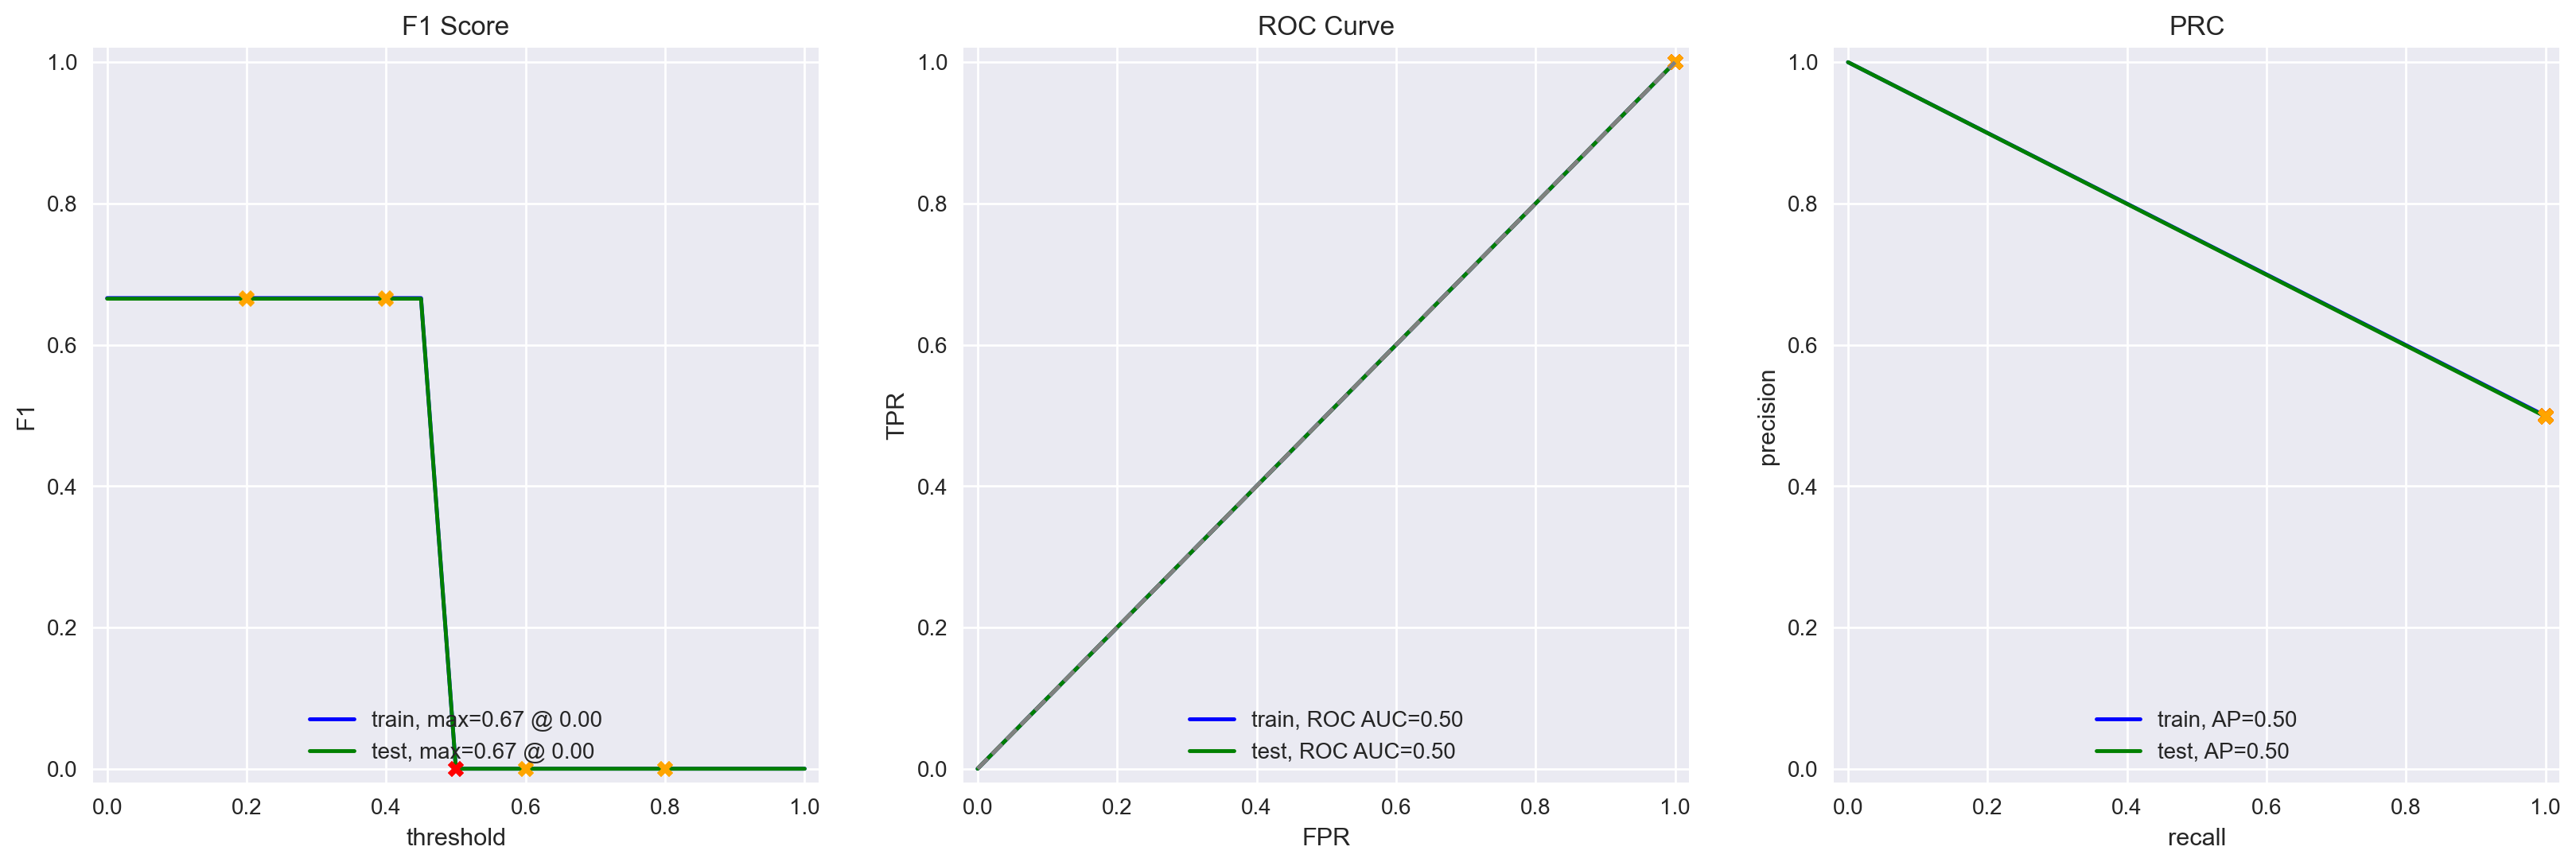

In [20]:
evaluate_model(model, f_train0, train_target, f_test0, test_target)

A pontuação F1 para o conjunto de teste é `0,5`. Os modelos subsequentes precisam ser melhores que este.

### Modelo 1 - NLTK, TF-IDF e LR <a name='62'></a>

TF-IDF

In [21]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

Características

In [22]:
corpus_train = []
corpus_test = []

In [23]:
#Corpus de treinamento
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    corpus_train.append(l_join)

In [24]:
#Corpus de teste
for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    corpus_test.append(l_join)

In [25]:
#Vectorizando os corpus com o TF-IDF Vectorizer com english stopwords e unigramas
count_tf_idf2 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))
train_features_1 = count_tf_idf2.fit_transform(corpus_train)
test_features_1 = count_tf_idf2.transform(corpus_test)

Treinando o modelo

In [26]:
model_1 = LogisticRegression(C=0.5).fit(train_features_1, train_target)

Avaliando o modelo usando a rotina de avaliação

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


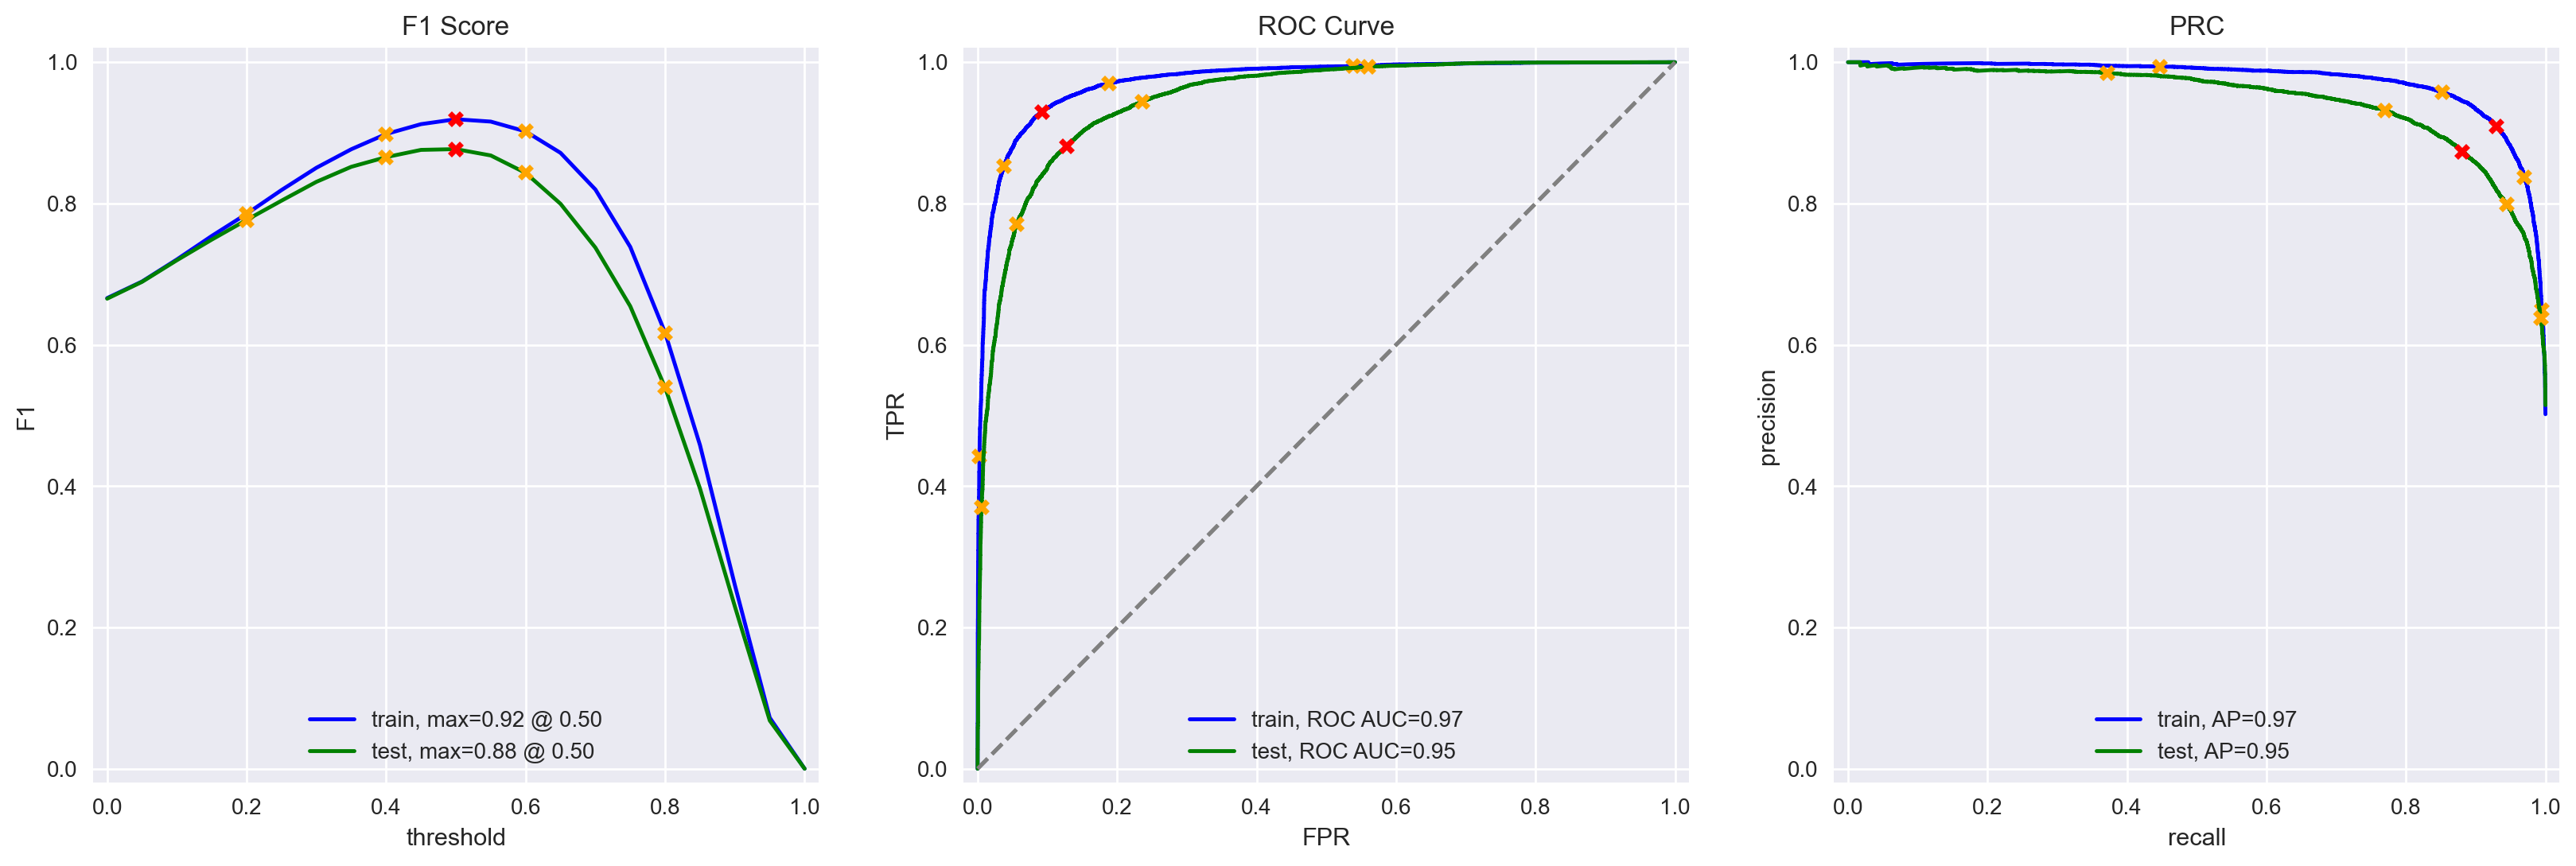

In [27]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

A pontuação F1 no conjunto de teste é `0,88`, significativamente superior à do dummy classifier e acima do limite mínimo estabelecido.

### Modelo 2 - spaCy, TF-IDF e LR <a name='63'></a>

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
#Função que processa e lematiza o texto
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [30]:
#Características
c_train3 = []
c_test3 = []

#Corpus de Treinamento
for text in df_reviews_train['review_norm']:
    result = text_preprocessing_3(text)
    c_train3.append(result)

#Corpus de Teste
for text in df_reviews_test['review_norm']:
    result = text_preprocessing_3(text)
    c_test3.append(result)

#Vectorizando os corpus    
count_tf_idf3 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))
f_train3 = count_tf_idf3.fit_transform(c_train3)
f_test3 = count_tf_idf3.transform(c_test3)

Treinando o modelo

In [31]:
model_2 = LogisticRegression(C=0.5).fit(f_train3, train_target)

Avaliando o modelo

          train  test
Accuracy   0.91  0.87
F1         0.92  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


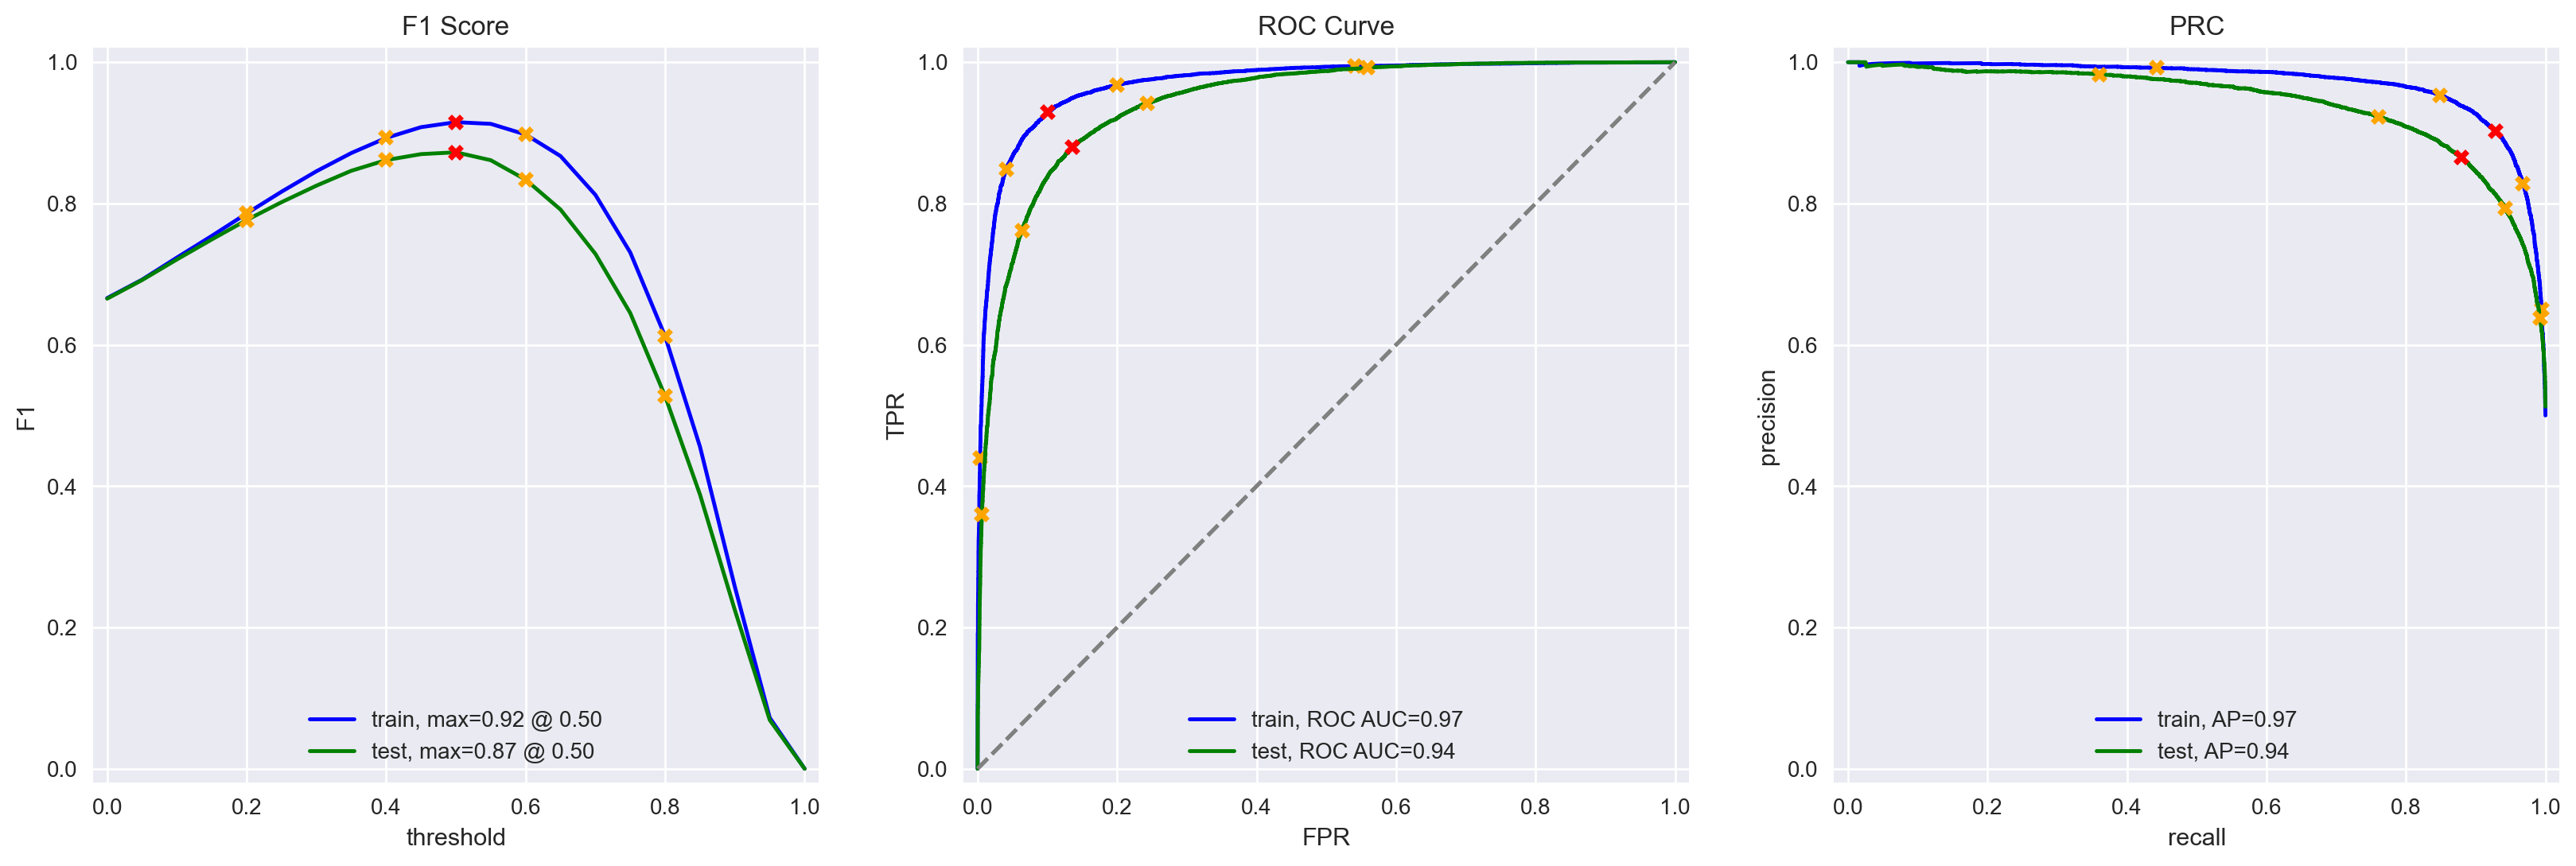

In [32]:
evaluate_model(model_2, f_train3, train_target, f_test3, test_target)

A pontuação F1 para o conjunto de teste é `0,87`, um pouco menos que a anterior, mas ainda acima do limite mínimo

### Modelo 3 - spaCy, TF-IDF and LGBMClassifier <a name='64'></a>

Uma vez que ainda estamos utilizando spaCy e TF-IDF, podemos aproveitar os valores vetorizados obtidos do último modelo. O próximo passo será encontrar os melhores parâmetros para treinar o LightGBM Classifier.

In [33]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [34]:
#Encontrando os melhores parâmetros para o modelo
model = LGBMClassifier()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['binary'],
            'random_state':[12345]}
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train3, train_target)
best_param = grid.best_params_

In [35]:
print('Melhor pontuação dos parâmetros pesquisados:', grid.best_score_)
print('Melhores parâmetros:', best_param)

Melhor pontuação dos parâmetros pesquisados: 0.8339086638689276
Melhores parâmetros: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'objective': 'binary', 'random_state': 12345}


In [36]:
#treinando e testando usando os melhores parâmetros
model_3 = LGBMClassifier(num_leaves=best_param['num_leaves'],
                        learning_rate=best_param['learning_rate'],
                        n_estimators=best_param['n_estimators'],
                        objective='binary',
                        random_state=12345)
model_3.fit(f_train3, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=20, num_leaves=30,
               objective='binary', random_state=12345)

Avaliação do modelo

          train  test
Accuracy   0.89  0.84
F1         0.89  0.84
APS        0.96  0.92
ROC AUC    0.96  0.92


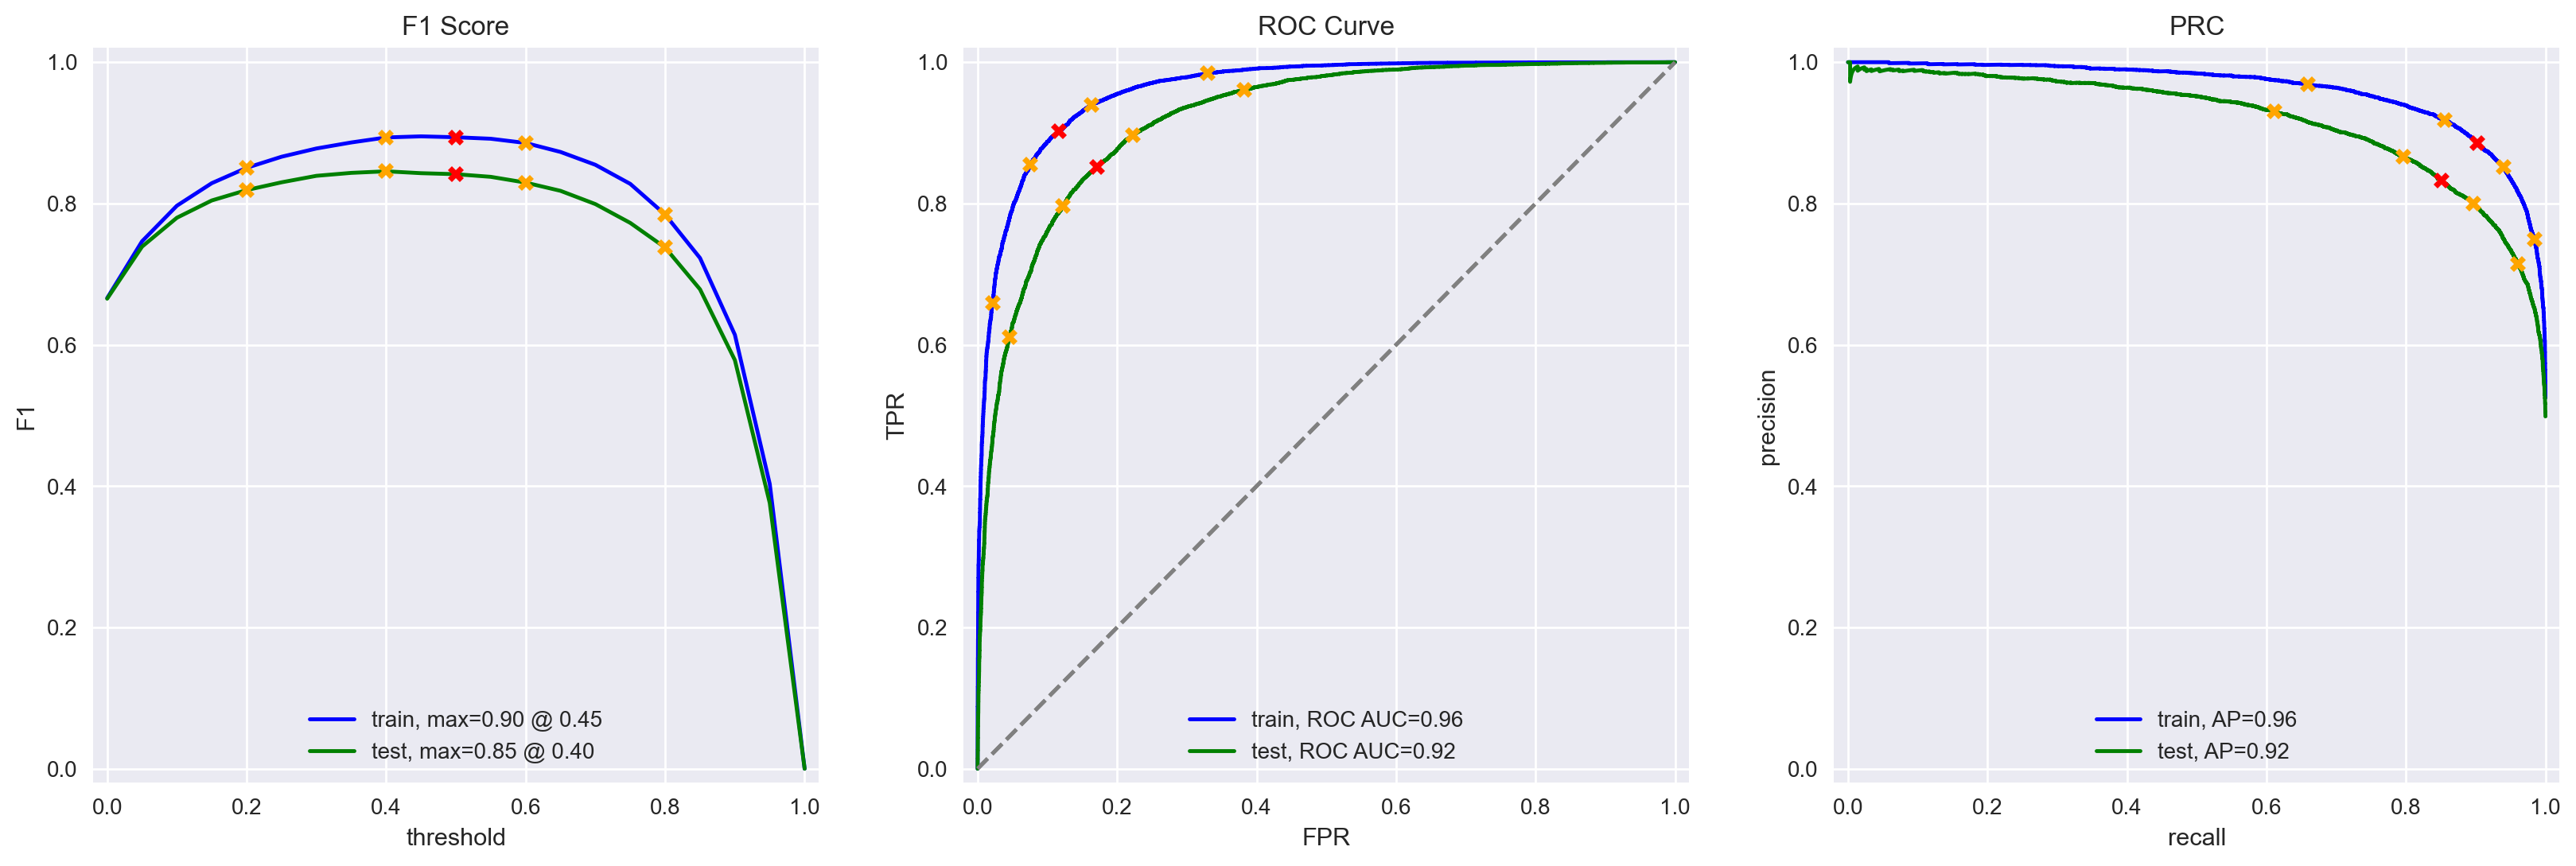

In [37]:
evaluate_model(model_3, f_train3, train_target, f_test3, test_target)

A pontuação F1 é de `0,84`, um pouco abaixo do requisito mínimo

## Testando os Modelos <a name='7'></a>

In [38]:
#Criando um dataframe com resenhas teste

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'], columns=['review'])


my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]
my_reviews

,review,review_norm,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,1


### Modelo 1

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.29:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.23:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.44:  i didn t expect the reboot to be so good writers really cared about the source material
0.45:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.15:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


O modelo fornece probabilidades de positividade mais baixas para as 5ª e 6ª avaliações, que são positivas.

### Modelo 2

In [40]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.15:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.20:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.38:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.08:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Este modelo teve maior probabilidade de atribuir avaliações negativas do que avaliações positivas, pois acertou todas as probabilidades das avaliações negativas e errou as probabilidades das avaliações positivas, exceto pela última resenha.

### Modelo 3

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.50:  i did not simply like it not my kind of movie
0.24:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.46:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.69:  i didn t expect the reboot to be so good writers really cared about the source material
0.57:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.72:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Este modelo cometeu apenas 1 erro de probabilidade, na primeira resenha. Além disso, ele não é tão extremo quanto os outros modelos, com uma probabilidade máxima de 72%, em comparação com 85% e 84% dos outros.

## Conclusão <a name='8'></a>

Uma análise foi realizada dos dados e observamos um aumento geral no número de filmes por ano, atingindo o ápice em 2006 e, posteriormente, diminuindo. Notamos que, em geral, menos filmes tiveram um maior número de avaliações, e que houve mais avaliações negativas por ano do que avaliações positivas. Procedemos com o treinamento de diversos modelos para prever se uma avaliação seria positiva ou negativa. O modelo de Regressão Logística, utilizando o processamento NLTK e o Vetorizador TF-IDF, obteve o melhor escore F1 (0,88). Não foi treinado um modelo BERT devido à falta de poder de processamento necessário.